In [34]:
#Import Libraries (I did not use some of the imported libraries)

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession

In [2]:
# Find Spark's folder
import findspark
findspark.init('/home/bharat/spark-3.1.1-bin-hadoop2.7')

In [3]:
# Create a Sparkcontext

import pyspark
from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

In [4]:
# Download and load the training text and training variants data provided in the Kaggle Competition website 
#https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
# Add the path of the directories where the training_text and training_variants files are present
training_text = pd.read_csv('/home/bharat/Desktop/..../msk-redefining-cancer-treatment/training_text/training_text', sep = "\|\|", engine='python',
                           names = ['ID', 'TEXT'], skiprows = 1)
training_variants = pd.read_csv('/home/bharat/Desktop/...../msk-redefining-cancer-treatment/training_variants/training_variants')

In [5]:
# Merge the training text and training variants files to create a single dataframe

training_text = pd.merge(training_variants,training_text, how = 'left')
training_text.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# Check for null values
training_text.isnull().any()

ID           False
Gene         False
Variation    False
Class        False
TEXT          True
dtype: bool

In [7]:
# Print null values
print("No of null values in TEXT data are :" , training_text['TEXT'].isnull().sum())

No of null values in TEXT data are : 5


In [8]:
# Display null values

training_text[training_text.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
# View the initial row entries of the dataframe
training_text.head(20)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...


In [10]:
# Convert the dataframe to a list
training_text_list= training_text.values.tolist()

In [11]:
# Load stopwords

stop_words = set(stopwords.words('english'))

In [12]:
# Define a function for basic NLP processing operations
def nlp_prepocesssing1(total_text):
    if type(total_text) is not int:
        string = ""
        
        #replace every special character with a single space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace multiple spaces with a single space
        total_text = re.sub('\s+', ' ', total_text)
        
        #convert all characters to lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #if the word is not in stopwords,store it
            if not word in stop_words:
                string += word + " "
                
    return string

In [13]:
# Replace null values with Gene - Variation combination
# Do Preprocessing of the text
import time
start = time.time()

training_data_processed=sc.parallelize(training_text_list[1:]).map(lambda x: [x[0],x[1],x[2],x[3],nlp_prepocesssing1(x[4])] if type(x[4]) is str else [x[0],x[1],x[2],x[3],x[1] +' '+x[2]]).collect()

end = time.time()
print("Time took for preproceesing = ", end-start, 'seconds')  

Time took for preproceesing =  7.520937919616699 seconds


In [15]:
# Convert the training_data_processed list to a dataframe
training_data_processed_df_normal= pd.DataFrame(training_data_processed,columns=['ID','Gene','Variation','Class','Text'])

In [16]:
training_data_processed_df_normal.head(20)

,ID,Gene,Variation,Class,Text
0,1,CBL,W802*,2,abstract background non small cell lung cancer...
1,2,CBL,Q249E,2,abstract background non small cell lung cancer...
2,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
3,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
4,5,CBL,V391I,4,oncogenic mutations monomeric casitas b lineag...
5,6,CBL,V430M,5,oncogenic mutations monomeric casitas b lineag...
6,7,CBL,Deletion,1,cbl negative regulator activated receptor tyro...
7,8,CBL,Y371H,4,abstract juvenile myelomonocytic leukemia jmml...
8,9,CBL,C384R,4,abstract juvenile myelomonocytic leukemia jmml...
9,10,CBL,P395A,4,oncogenic mutations monomeric casitas b lineag...


In [17]:
# Store class values in y_train and replace whitespace by underscore in Gene and Variation fields 
y_train = training_data_processed_df_normal['Class'].values
training_data_processed_df_normal.gene = training_data_processed_df_normal.Gene.str.replace('\s+', '_')
training_data_processed_df_normal.variation = training_data_processed_df_normal.Variation.str.replace('\s+', '_')

In [18]:
# Create a dataframe train_df 
train_df=training_data_processed_df_normal

In [19]:
# Do one hot encoding of gene features
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])

In [20]:
# Do one hot encoding of mutation features
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])

In [21]:
# Define a function for creating a dictionary from the Text column of row entries 
import collections
def extract_dictionary_paddle(cls_text):
    dictionary = collections.defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [22]:
# Vectorize the features of the Text Column
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])
# Get all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occurred
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 65946


In [23]:
# Create class specific word dictionaries and combine them to create a dictionary for the whole training dataset 
dict_list = []

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(train_df)

'\nconfuse_array = []\nfor i in train_text_features:\n    ratios = []\n    max_val = -1\n    for j in range(0,9):\n        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))\n    confuse_array.append(ratios)\nconfuse_array = np.array(confuse_array)\n'

In [24]:
# Do OHE for Genes, Mutations , Features and create a combined vector with all these values for each row 
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

train_x_onehotCoding_df = pd.DataFrame(train_x_onehotCoding.toarray())
train_x_onehotCoding_df.columns = ['f' + str(col) for col in train_x_onehotCoding_df.columns]
train_y_df = pd.DataFrame(train_y)
training_df=pd.concat([train_y_df,train_x_onehotCoding_df], axis=1)
training_temp=training_df.rename(columns={training_df.columns[0]: 'Label'})
training_df=training_temp
del training_temp 

In [28]:
# View the first few rows of the vectorized dataset
training_df.head(5)

,Label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f69219,f69220,f69221,f69222,f69223,f69224,f69225,f69226,f69227,f69228
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Move the label column from the first to the fifth position (There is no math behind this, just for 
# making it suitable for processing by the csv2libsvm1.py in the next step )
cols = training_df.columns.tolist()
cols = cols[1:5] + cols[:1]+ cols[5:] 
training_df = training_df[cols]

In [31]:
# Convert the training_df to a csv file
training_df.to_csv (r'/home/bharat/Desktop/.../training_df.csv', index = False, header=True)

In [32]:
# Create a libsvm data file from the training_df.csv file so that it can be used by Spark MLlib
%run -i 'csv2libsvm1.py' training_df.csv libsvm.data 4 True

In [35]:
# Train the MLR model in SparkMLlib

from pyspark.ml.classification import LogisticRegression


spark = SparkSession \
        .builder \
        .appName("MulticlassLogisticRegressionWithElasticNet") \
        .getOrCreate()

# Load training data

#.format("csv") \

training = spark \
    .read \
    .format("libsvm") \
    .load("/home/bharat/Desktop/...../libsvm.data")

training,test=training.randomSplit([0.8, 0.2])

lr = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=1)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass classification, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
10 X 69229 CSRMatrix
(1,56) 1.1443
(1,75) 1.8042
(1,98) 1.0795
(1,109) 0.3863
(1,161) 1.8295
(1,196) 1.9733
(1,228) 1.6588
(1,230) 0.5105
(1,250) 1.728
(1,267) 1.4648
(1,278) 1.5206
(1,312) 1.0842
(1,319) 1.4567
(1,328) 0.0252
(1,359) 1.2297
(1,382) 0.1694
..
..
Intercept: [-149.63817825339083,17.460899681992423,17.366839196615718,16.101996515653052,17.425652023201604,17.001505451089717,16.747390767435757,17.95808262378766,14.769799305274699,14.806012688340228]
objectiveHistory:
1.8300942016808381
1.6911408086566349
1.5377902070534237
1.4680215414582751
1.411551618028245
1.3723266231164715
1.3334665181418397
1.2918490939597105
1.257959606045928
1.2295526017238196
1.201044427952321
1.1687974917590256
1.1264827501120034
1.1016076279294245
1.0896452214160475
1.0808590262532785
1.0684501849672563
1.0606216032546847
1.0534604914389525
1.0467265854850762
1.0397671013785066
1.0371112275427872
1.0341476587849232
1.0305541822136894
1.0274149533344417
1.0272280672380532
1.02549902

In [38]:
# Predict the values for the test set
predictions = lrModel.transform(test)

In [39]:
# View initial few rows of the predicted values dataframe

import pyspark
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

predictions.shape()
predictions.printSchema()
predictions_df=predictions.toPandas()
predictions_df.head()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



,label,features,rawPrediction,probability,prediction
0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-149.63817825339083, 20.69284290875838, 17.54...","[6.340441257634739e-75, 0.596955655417545, 0.0...",1.0
1,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-149.63817825339083, 18.921426977337305, 17.4...","[2.8781826497946347e-74, 0.460919173385158, 0....",1.0
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-149.63817825339083, 22.349791002922448, 17.9...","[1.7575265397768146e-75, 0.8676166817195887, 0...",1.0
3,2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-149.63817825339083, 17.545445276245587, 18.0...","[2.0150267915118035e-74, 0.08150907945560468, ...",7.0
4,4.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-149.63817825339083, 17.557166327919408, 17.4...","[2.8819204678776694e-74, 0.11794989076886694, ...",4.0


In [40]:
# Define a function to plot the confusion, precision and recall matrices
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =((((C.T)/C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*25, "Confusion matrix", "-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

------------------------- Confusion matrix -------------------------


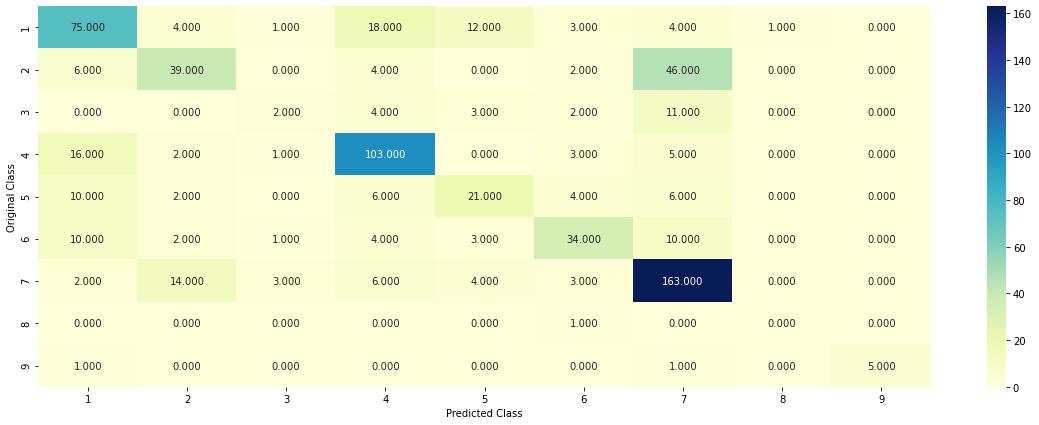

-------------------- Precision matrix (Columm Sum=1) --------------------


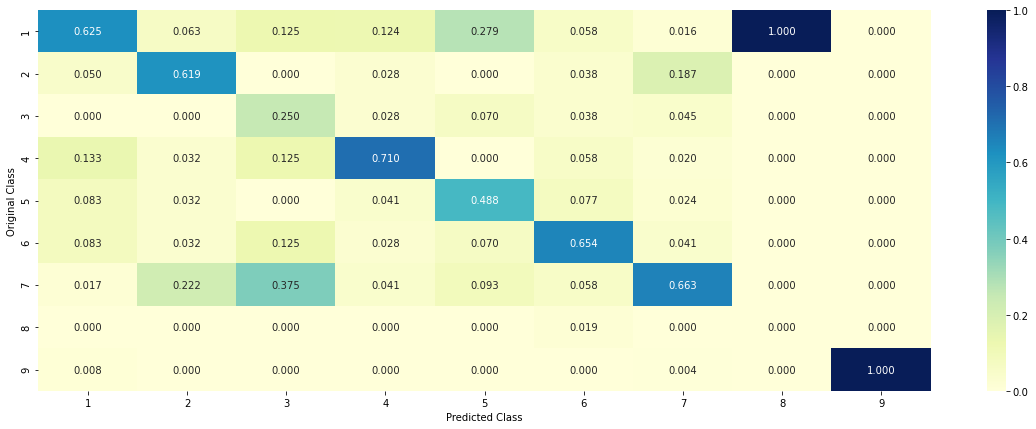

-------------------- Recall matrix (Row sum=1) --------------------


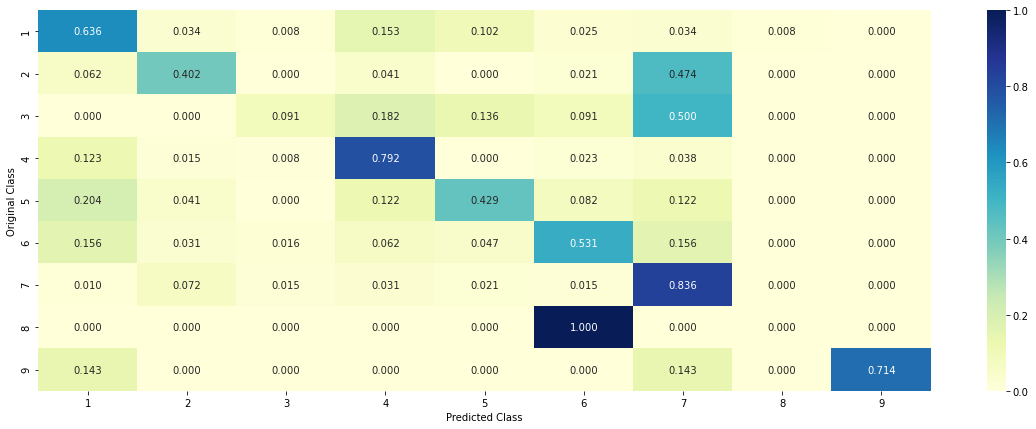

In [41]:
plot_confusion_matrix(predictions_df['label'], predictions_df['prediction'])

In [42]:
# Compute the fraction of mis-classified points 
print("Number of mis-classified points :", np.count_nonzero((predictions_df['prediction']- predictions_df['label']))/predictions_df['label'].shape[0])

Number of mis-classified points : 0.3528550512445095
